In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1743.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_262.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1336.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1461.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1797.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1499.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1170.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1259.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_422.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_636.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1395.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1800.jpg
/kaggle/input/plant-patholog

/kaggle/input/plant-pathology-2020-fgvc7/images/Test_924.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_455.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1344.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_154.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1310.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_66.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_325.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_196.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_725.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_499.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1615.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1140.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_764.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_989.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1338.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1478.jpg
/kaggle/in

In [2]:
import numpy as np
import pandas as pd 
import os
import cv2
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

%matplotlib inline

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMG_SIZE = 768

print('Batch size:', BATCH_SIZE)

Running on TPU: grpc://10.0.0.2:8470
Batch size: 64


In [14]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

print(train.head())

train_path = train.image_id.apply(lambda x: f'{GCS_DS_PATH}/images/{x}.jpg').values
test_path = test.image_id.apply(lambda x: f'{GCS_DS_PATH}/images/{x}.jpg').values
train_label = train.loc[:, 'healthy':].values

train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label,
                                                                    test_size=0.1, stratify=train_label)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3], y=[3 1 0 ... 0 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


<BarContainer object of 4 artists>

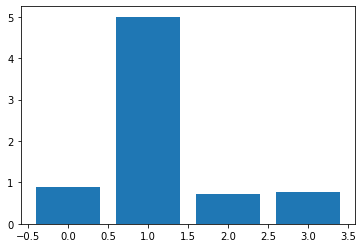

In [5]:
class_weight = compute_class_weight('balanced', np.unique(np.argmax(train_label, axis=1)), np.argmax(train_label, axis=1))
plt.bar(range(4), class_weight)

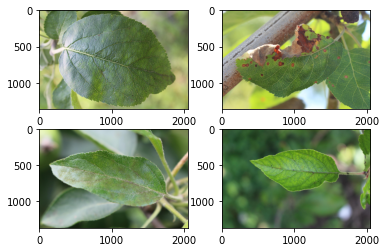

In [6]:
fig, ax = plt.subplots(2, 2)
img = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_5.jpg')
img1 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1.jpg')
img2 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_7.jpg')
img3 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_9.jpg')
ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0, 1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[1, 0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1, 1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

In [7]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [15]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((train_path, train_label))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((valid_path, valid_label))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(test_path)
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

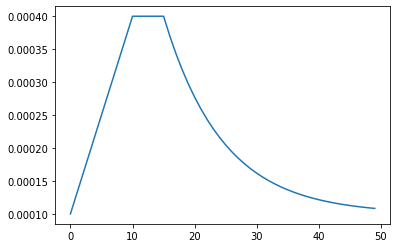

In [9]:
EPOCHS = 50
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 5
LR_EXP_DECAY = .9

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr = tf.keras.callbacks.LearningRateScheduler(lrfn)

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

In [10]:
!pip install -q efficientnet

In [11]:
from efficientnet.tfkeras import EfficientNetB7

with strategy.scope():
    efn = EfficientNetB7(include_top=False, weights='noisy-student', pooling='max', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(efn)
    model.add(L.Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

258072576/258068648 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________
None


In [12]:
mc = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='loss', save_best_only=True, save_weights_only=True)
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[lr, mc], steps_per_epoch=train_label.shape[0] // BATCH_SIZE)

Epoch 1/50
28/28 [==============================] - 288s 1s/step - loss: 4.1108 - accuracy: 0.3178
Epoch 2/50
28/28 [==============================] - 28s 996ms/step - loss: 1.3364 - accuracy: 0.5948
Epoch 3/50
28/28 [==============================] - 28s 1s/step - loss: 0.7032 - accuracy: 0.7903
Epoch 4/50
28/28 [==============================] - 28s 1s/step - loss: 0.5255 - accuracy: 0.8400
Epoch 5/50
28/28 [==============================] - 28s 1s/step - loss: 0.4545 - accuracy: 0.8649
Epoch 6/50
28/28 [==============================] - 29s 1s/step - loss: 0.3397 - accuracy: 0.8999
Epoch 7/50
28/28 [==============================] - 28s 1s/step - loss: 0.4051 - accuracy: 0.8949
Epoch 8/50
28/28 [==============================] - 28s 990ms/step - loss: 0.3321 - accuracy: 0.9050
Epoch 9/50
28/28 [==============================] - 28s 992ms/step - loss: 0.2714 - accuracy: 0.9211
Epoch 10/50
28/28 [==============================] - 28s 989ms/step - loss: 0.1837 - accuracy: 0.9396
Epoch 

In [ ]:
with strategy.scope():
    model.load_weights('weights.h5')
valid_prob = model.predict(valid_dataset, verbose=1)
print(metrics.classification_report(np.argmax(valid_label, axis=1), np.argmax(valid_prob, axis=1)))
print(metrics.confusion_matrix(np.argmax(valid_label, axis=1), np.argmax(valid_prob, axis=1)))

In [ ]:
probs = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs
# sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
#If u like this Kernel, Upvote this Kernel